In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier

In [19]:
df = pd.read_parquet('ST data.parquet')
data = df.copy()
train, test = data[data.date <= '20231231'], data[data.date >= '20240101']
X_train, y_train = train.drop(['date', 'code', 'is_st'], axis=1), train['is_st']
X_test, y_test = test.drop(['date', 'code', 'is_st'], axis=1), test['is_st']
sampler = RandomOverSampler(random_state=1)
X_rsl, y_rsl = sampler.fit_resample(X_train, y_train)

parameters = {'n_estimators': 100, 'max_depth': 7, 'reg_alpha': 8, 'reg_lambda': 8, 'Gamma': 8}
model_xgb = XGBClassifier(n_estimators=100, max_depth=7, reg_alpha=8, reg_lambda=8, gamma=8,
                          objective="binary:logistic", eval_metric="auc", seed=123)
model_xgb.fit(X_rsl, y_rsl)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_pr = model_xgb.predict_proba(X_test)

In [20]:
fpr_xgb, tpr_xgb, thr_xgb = roc_curve(y_test, y_pred_pr[:, 1])
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("AUC Score: {}".format(auc_xgb))
mat = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]


# 计算准确率、正确率、召回率、F1得分
def compute_indexes(tp, fp, tn, fn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = (2 * precision * recall) / (precision + recall)
    return accuracy, precision, recall, F1


compute_indexes(tp, fp, tn, fn)

AUC Score: 0.9702419103827978


(0.9526992287917738,
 0.36419753086419754,
 0.862012987012987,
 0.5120540019286404)

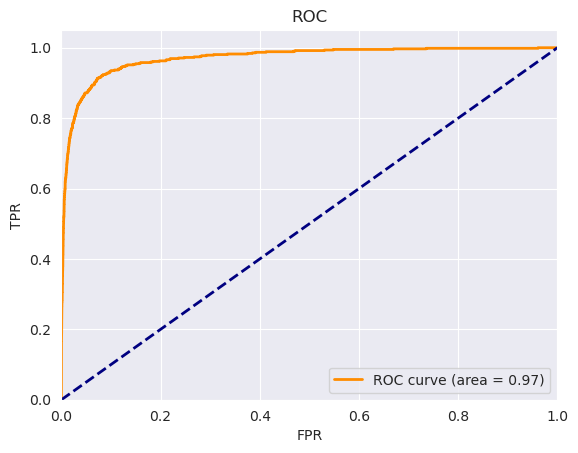

In [26]:
# 画出ROC曲线
plt.figure()  
lw = 2  
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_xgb)  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('FPR')  
plt.ylabel('TPR')  
plt.title('ROC')  
plt.legend(loc="lower right")  
plt.show()

In [21]:
# 从0.5到1根据F1得分选取最佳阈值
f1_score = np.zeros(50)
for p in np.arange(0.5, 1, 0.01):
    y_thr = y_pred_pr[:, 1].copy()
    y_thr[y_thr >= p] = 1
    y_thr[y_thr < p] = 0
    
    mat = confusion_matrix(y_test, y_thr)
    tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
    f1_score[int((p - 0.5) * 100)] = compute_indexes(tp, fp, tn, fn)[3]

In [24]:
np.argmax(f1_score)

41

In [25]:
y_thr = y_pred_pr[:, 1].copy()
y_thr[y_thr >= 0.91] = 1
y_thr[y_thr < 0.91] = 0

mat = confusion_matrix(y_test, y_thr)
tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
# 更改阈值后的各指标
compute_indexes(tp, fp, tn, fn)

(0.9813040430007011, 0.6942446043165468, 0.6266233766233766, 0.658703071672355)

In [30]:
# 网格搜索找出最优参数（由于参数较多且需使用交叉验证，耗时较长）
parameters = {"learning_rate": np.arange(0.05, 0.31, 0.05), "n_estimators":range(10,101,10), "max_depth":range(3, 11, 1)}

xgb_grid = GridSearchCV(model_xgb, parameters, scoring="roc_auc")
xgb_grid.fit(X_rsl, y_rsl)
print("The best parameters are: ", xgb_grid.best_params_)
y_pred_bp = xgb_grid.predict_proba(X_test)
fpr_bp, tpr_bp, thr_bp = roc_curve(y_test, y_pred_bp[:, 1])
auc_bp = auc(fpr_bp, tpr_bp)
print("Test AUC of XGB after hyper-parameter tuning: {}".format(auc_bp))

The best parameters are:  {'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 90}
Test AUC of XGB after hyper-parameter tuning: 0.9737278458583621


In [31]:
f1_score = np.zeros(50)
for p in np.arange(0.5, 1, 0.01):
    y_thr = y_pred_bp[:, 1].copy()
    y_thr[y_thr >= p] = 1
    y_thr[y_thr < p] = 0
    
    mat = confusion_matrix(y_test, y_thr)
    tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
    f1_score[int((p - 0.5) * 100)] = compute_indexes(tp, fp, tn, fn)[3]

In [32]:
f1_score

array([0.58155231, 0.58262351, 0.58816772, 0.59302326, 0.59811986,
       0.60189573, 0.60587882, 0.6095932 , 0.61226994, 0.62056075,
       0.62358846, 0.62618596, 0.62875399, 0.62813102, 0.63376623,
       0.63905325, 0.64499005, 0.64926372, 0.65226199, 0.65258856,
       0.65521978, 0.66112266, 0.66293706, 0.66432584, 0.66572238,
       0.66809422, 0.67243867, 0.67538126, 0.67744306, 0.6795539 ,
       0.67878788, 0.67794005, 0.68015564, 0.68081761, 0.67621321,
       0.67692308, 0.67702371, 0.68272425, 0.6823135 , 0.68479184,
       0.67761452, 0.67961165, 0.67148014, 0.66422018, 0.66106443,
       0.64947469, 0.63573544, 0.61977574, 0.56832972, 0.47980998])

In [33]:
np.argmax(f1_score)

39

In [34]:
y_thr = y_pred_bp[:, 1].copy()
y_thr[y_thr >= 0.89] = 1
y_thr[y_thr < 0.89] = 0

mat = confusion_matrix(y_test, y_thr)
tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
compute_indexes(tp, fp, tn, fn)

(0.9826594998831503,
 0.7183600713012478,
 0.6542207792207793,
 0.6847918436703484)

In [ ]:
# 绘制特征重要性排序
xgb.plot_importance(model_xgb, max_num_features=8)
plt.show()

In [ ]:
xgb_importance = model_xgb.feature_importances_(type)
print(xgb_importance)

In [ ]:
# 绘制并保存决策树
xgb.plot_tree(model_xgb, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')